In [3]:
from kedro.framework.context import load_context
from kedro.config import ConfigLoader
from kedro.io import DataCatalog
from pathlib import Path

conf_loader = ConfigLoader(['../conf/base'])
conf_catalog = conf_loader.get("catalog*", "catalog/**")
new_catalog = DataCatalog.from_config(conf_catalog)

current_dir = Path.cwd()  # this points to 'notebooks/' folder
proj_path = current_dir.parent  # point back to the root of the project
context = load_context(proj_path)

In [4]:
from pathlib import Path
from kedro.framework.context import load_context

current_dir = Path.cwd()  # this points to 'notebooks/' folder
proj_path = current_dir.parent  # point back to the root of the project
context = load_context(proj_path)

In [5]:
%%time
df = context.catalog.load("ibov_dataset")
df.head()

2020-08-03 21:03:54,642 - kedro.io.data_catalog - INFO - Loading data from `ibov_dataset` (AppendableCSVDataSet)...
Wall time: 4.4 s


,data_pregao,cod_papel,preco_ultimo,num_negocios
0,2000-01-04 00:00:00,AVIL4FF,35.00,3.0
1,2000-01-05 00:00:00,AVIL4FF,35.00,2.0
2,2000-01-03 00:00:00,BBDC3FF,11.30,4.0
3,2000-01-03 00:00:00,BBDC4FF,13.87,36.0
4,2000-01-04 00:00:00,BBDC3,10.11,42.0


In [6]:
carteira = ['BBAS3','ITSA4','ITUB4','JBSS3','JHSF3','ODPV3','STBP3','MGLU3','BBSE3', 'CVCB3', 'BIDI4']
df_cart = df.loc[df.cod_papel.isin(carteira), :]
df_cart = df_cart.drop_duplicates(subset=['data_pregao','cod_papel','preco_ultimo'])
df_cart = df_cart.pivot(index = 'data_pregao', columns='cod_papel', values='preco_ultimo')

2020-08-03 21:04:15,826 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


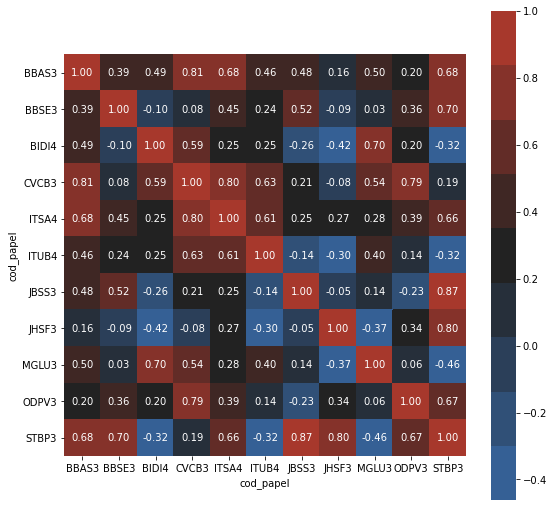

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="dark")
_, ax = plt.subplots(figsize=(9, 9))
corr = df_cart.corr()

sns.heatmap(corr, cmap=cm, square=True, ax=ax, annot=True, fmt=".2f")
plt.yticks(rotation=0);

In [52]:
df.head()

,data_pregao,cod_papel,preco_ultimo,num_negocios
0,2000-01-04 00:00:00,AVIL4FF,35.00,3.0
1,2000-01-05 00:00:00,AVIL4FF,35.00,2.0
2,2000-01-03 00:00:00,BBDC3FF,11.30,4.0
3,2000-01-03 00:00:00,BBDC4FF,13.87,36.0
4,2000-01-04 00:00:00,BBDC3,10.11,42.0


In [50]:
import pandas as pd

def get_top_stocks(df: pd.DataFrame, floor_trades: int, cols: list) -> pd.DataFrame:
    trades = df.groupby('cod_papel').num_negocios.sum()
    stocks = list(trades[trades>floor_trades].index)
    return df[cols].loc[df.cod_papel.isin(stocks), :].drop_duplicates()

# dates = ['2020-03-02 00:00:00', '2020-07-31 00:00:00']
# df_res = df.loc[df.data_pregao.isin(dates), ['data_pregao', 'cod_papel', 'preco_ultimo']]
# df_res = df_res.drop_duplicates(subset=['data_pregao','cod_papel','preco_ultimo'])
# df_res = df_res.pivot_table(index='data_pregao', columns='cod_papel', values='preco_ultimo')
# resilients = df_res.transpose().dropna()
# (resilients.iloc[:,1]/resilients.iloc[:,0]).sort_values().iloc[-40:-1]
dates = ['2020-03-02 00:00:00', '2020-07-31 00:00:00']
cols = ['data_pregao', 'cod_papel', 'preco_ultimo', 'num_negocios']
floor_trandes = 1000000
df_top = df_top.loc[df_top.data_pregao.isin(dates), :]
df_top = get_top_stocks(df_top, floor_trandes, cols)
df_top = df_res.pivot_table(index='data_pregao', columns='cod_papel', values='preco_ultimo')
df_top.head()

AttributeError: 'DataFrameGroupBy' object has no attribute 'num_negocios'